In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
conn_str = (
    "DRIVER={ODBC Driver 18 for SQL Server};"
    "SERVER=localhost;"               # default instance
    "DATABASE=DW_Education;"
    "Trusted_Connection=yes;"
    "TrustServerCertificate=yes;"
)

conn = pyodbc.connect(conn_str)
if conn:
    print("Connected successfully")

Connected successfully


In [3]:
query = """
SELECT
    f.IPS,
    f."Taux de réussite" AS Taux_Reussite,
    f."Taux de mentions" AS Taux_Mentions,
    f.Nb_eleves,

    -- Geographic info
    g.Code_postal AS Code_Postal,
    g.Nom_commune AS Ville,
    g.Libelle_region AS Region,

    -- Etablissement info
    e.UAI AS UAI,
    e.Nom_etablissement AS Nom_Etablissement,
    e.Statut_public_prive AS Statut_Etablissement,

    -- Date info
    d.Annee,
    d.Mois,
    d.Jour,

    -- Section info
    s.Code_Section,

    -- Voie info
    v.Code_Voie,

    -- Type Etablissement info
    t.Code_TypeEtab,

    -- Service info
    srv.Code_Service

FROM dbo.factEtablissement2 AS f

-- Join each dimension
LEFT JOIN dbo.dim_geographie AS g
    ON f.Geographie_FK = g.Geographie_PK

LEFT JOIN dbo.dim_etablissment AS e
    ON f.Etablissment_FK = e.Etablissment_PK

LEFT JOIN dbo.dim_Date AS d
    ON f.Date_FK = d.Date_PK

LEFT JOIN dbo.dim_Section AS s
    ON f.Section_FK = s.Section_PK

LEFT JOIN dbo.dim_Voie AS v
    ON f.Voie_FK = v.Voie_PK

LEFT JOIN dbo.dim_TypeEtablissement AS t
    ON f.TypeEtab_FK = t.TypeEtab_PK

LEFT JOIN dbo.dim_Service AS srv
    ON f.Service_FK = srv.Service_PK;

"""

df = pd.read_sql(query, conn)
df.head()

C:\Users\mk\AppData\Local\Temp\ipykernel_45600\2984369686.py:61: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,IPS,Taux_Reussite,Taux_Mentions,Nb_eleves,Code_Postal,Ville,Region,UAI,Nom_Etablissement,Statut_Etablissement,Annee,Mois,Jour,Code_Section,Code_Voie,Code_TypeEtab,Code_Service
0,112.1,None,NaN,160.0,62153,Souchez,Hauts-de-France,0623366X,Ecole élémentaire Anatole France,Public,1979.0,9.0,1.0,None,None,E,RES
1,83.0,None,NaN,199.0,25300,Pontarlier,Bourgogne-Franche-Comté,0251225W,Ecole primaire Louis Pergaud,Public,1970.0,5.0,22.0,None,None,E,RES
2,83.0,None,NaN,199.0,25300,Pontarlier,Bourgogne-Franche-Comté,0251225W,Ecole primaire Louis Pergaud,Public,1970.0,5.0,22.0,None,None,E,ULI
3,84.7,"76,10",25.0,656.0,62290,Noeux-les-Mines,Hauts-de-France,0624440P,Lycée polyvalent d'Artois,Public,2013.0,9.0,1.0,EUR,T,L,GRE
4,84.7,"76,10",25.0,656.0,62290,Noeux-les-Mines,Hauts-de-France,0624440P,Lycée polyvalent d'Artois,Public,2013.0,9.0,1.0,EUR,P,L,GRE


In [4]:
print(df.head())
print(df.info())
print(df.describe())

     IPS Taux_Reussite  Taux_Mentions  Nb_eleves Code_Postal            Ville  \
0  112.1          None            NaN      160.0       62153          Souchez   
1   83.0          None            NaN      199.0       25300       Pontarlier   
2   83.0          None            NaN      199.0       25300       Pontarlier   
3   84.7         76,10           25.0      656.0       62290  Noeux-les-Mines   
4   84.7         76,10           25.0      656.0       62290  Noeux-les-Mines   

                    Region       UAI                 Nom_Etablissement  \
0          Hauts-de-France  0623366X  Ecole élémentaire Anatole France   
1  Bourgogne-Franche-Comté  0251225W      Ecole primaire Louis Pergaud   
2  Bourgogne-Franche-Comté  0251225W      Ecole primaire Louis Pergaud   
3          Hauts-de-France  0624440P         Lycée polyvalent d'Artois   
4          Hauts-de-France  0624440P         Lycée polyvalent d'Artois   

  Statut_Etablissement   Annee  Mois  Jour Code_Section Code_Voie  \

In [5]:


df['Taux_Reussite'] = pd.to_numeric(df['Taux_Reussite'], errors='coerce')
df['Taux_Mentions'] = pd.to_numeric(df['Taux_Mentions'], errors='coerce')
df['IPS'] = pd.to_numeric(df['IPS'], errors='coerce')
df['Nb_eleves'] = pd.to_numeric(df['Nb_eleves'], errors='coerce')
df['Annee'] = pd.to_numeric(df['Annee'], errors='coerce')

In [6]:
numeric_cols = ['IPS', 'Taux_Reussite', 'Taux_Mentions', 'Nb_eleves', 'Annee']
categorical_cols = [
    'Region', 'Code_Section', 'Code_Voie',
    'Code_Service', 'Code_TypeEtab',
    'Statut_Etablissement'
]

df['Nb_eleves'] = df['Nb_eleves'].fillna(df['Nb_eleves'].median())
df['Taux_Reussite'] = df['Taux_Reussite'].fillna(df['Taux_Reussite'].median())
df['Taux_Mentions'] = df['Taux_Mentions'].fillna(df['Taux_Mentions'].mean())
df['IPS'] = df['IPS'].fillna(df['IPS'].mean())
df['Annee'] = df['Annee'].fillna(df['Annee'].median())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


In [7]:
df_grouped = df.groupby('UAI').agg({
'IPS': 'median',
'Taux_Reussite': 'median',
'Taux_Mentions': 'median',
'Nb_eleves': 'first',
'Region': lambda x: x.mode()[0],
'Code_TypeEtab': lambda x: x.mode()[0],
'Code_Section': lambda x: ','.join(sorted(set(x))),
'Code_Service': lambda x: ','.join(sorted(set(x))),
'Code_Voie': lambda x: ','.join(sorted(set(x))),
'Statut_Etablissement': 'first',
'Annee': 'median'
}).reset_index()


print(df_grouped.shape)

(51361, 12)


In [8]:
# Sections
df_grouped['Section_list'] = df_grouped['Code_Section'].str.split(',')
mlb_sec = MultiLabelBinarizer()
sec_dummies = pd.DataFrame(mlb_sec.fit_transform(df_grouped['Section_list']),
columns=[f'sec_{c}' for c in mlb_sec.classes_])


# Services
df_grouped['Service_list'] = df_grouped['Code_Service'].str.split(',')
mlb_srv = MultiLabelBinarizer()
srv_dummies = pd.DataFrame(mlb_srv.fit_transform(df_grouped['Service_list']),
columns=[f'srv_{c}' for c in mlb_srv.classes_])


# Voies
df_grouped['Voie_list'] = df_grouped['Code_Voie'].str.split(',')
mlb_voie = MultiLabelBinarizer()
voie_dummies = pd.DataFrame(mlb_voie.fit_transform(df_grouped['Voie_list']),
columns=[f'voie_{c}' for c in mlb_voie.classes_])


# Dataset final
df_final = pd.concat([df_grouped, sec_dummies, srv_dummies, voie_dummies], axis=1)

In [9]:
threshold = df_final['Nb_eleves'].median()
df_final['Nb_eleves_class'] = (df_final['Nb_eleves'] >= threshold).astype(int)


df_final['Nb_eleves_class'].value_counts()

Nb_eleves_class
1    25875
0    25486
Name: count, dtype: int64

In [10]:
y = df_final['Nb_eleves_class']


numeric_cols = ['IPS', 'Taux_Reussite', 'Taux_Mentions', 'Annee']
categorical_cols = ['Region', 'Code_TypeEtab', 'Statut_Etablissement']
multi_hot_cols = [c for c in df_final.columns if c.startswith(('sec_', 'srv_', 'voie_'))]


X = df_final[numeric_cols + categorical_cols + multi_hot_cols]

In [11]:
preprocessor = ColumnTransformer(
transformers=[
('num', StandardScaler(), numeric_cols),
('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
],
remainder='passthrough'
)


model = Pipeline(steps=[
('preprocessing', preprocessor),
('classifier', LogisticRegression(max_iter=1000))
])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
X, y,
test_size=0.2,
random_state=42,
stratify=y
)

In [13]:
model.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78      5098
           1       0.82      0.68      0.74      5175

    accuracy                           0.76     10273
   macro avg       0.77      0.77      0.76     10273
weighted avg       0.77      0.76      0.76     10273



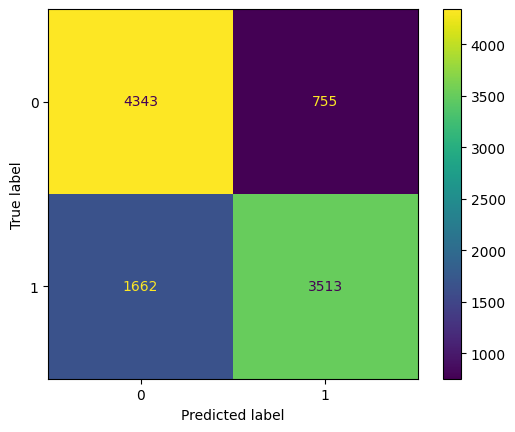

In [15]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [16]:
accuracy_score(y_test, y_pred)

0.7647230604497226

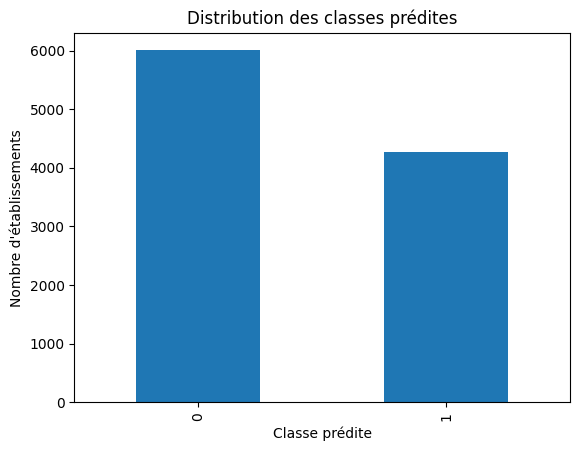

In [18]:
pred_df = pd.DataFrame({
"Réel": y_test,
"Prédit": y_pred
})


plt.figure()
pred_df["Prédit"].value_counts().plot(kind="bar")
plt.title("Distribution des classes prédites")
plt.xlabel("Classe prédite")
plt.ylabel("Nombre d'établissements")
plt.show()

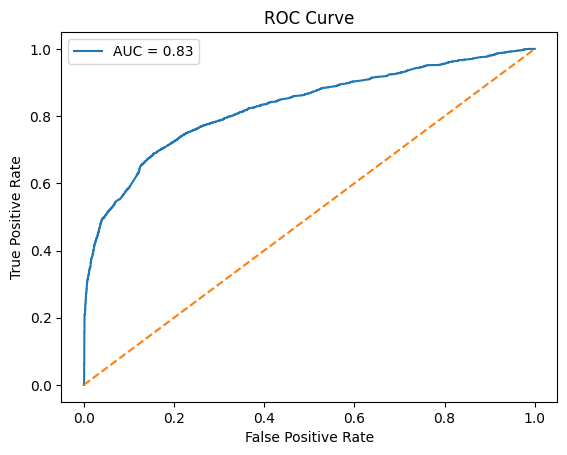

In [19]:
from sklearn.metrics import roc_curve, auc


y_proba = model.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

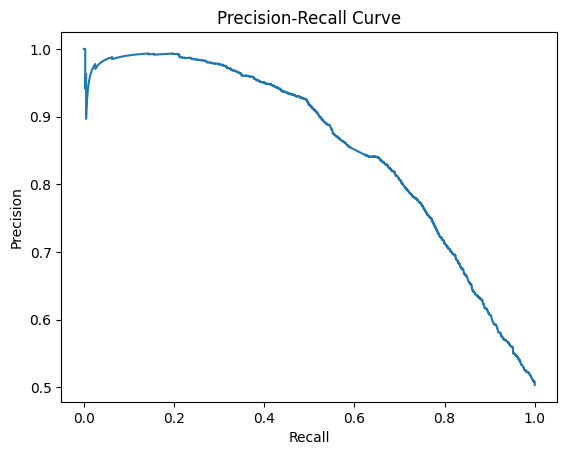

In [20]:
from sklearn.metrics import precision_recall_curve


precision, recall, _ = precision_recall_curve(y_test, y_proba)


plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

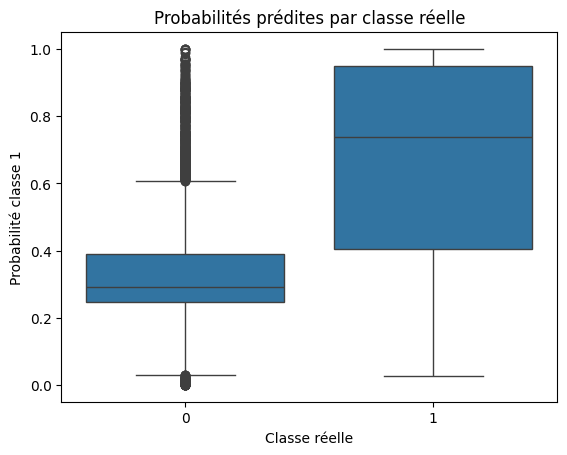

In [21]:
proba_df = pd.DataFrame({
"Probabilité classe 1": y_proba,
"Classe réelle": y_test
})


plt.figure()
sns.boxplot(data=proba_df, x="Classe réelle", y="Probabilité classe 1")
plt.title("Probabilités prédites par classe réelle")
plt.show()

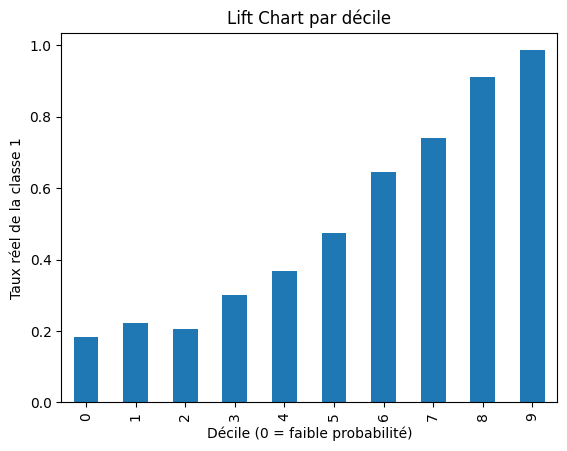

In [25]:
proba_df["decile"] = pd.qcut(proba_df["Probabilité classe 1"], 10, labels=False)


lift = proba_df.groupby("decile")["Classe réelle"].mean()


plt.figure()
lift.plot(kind="bar")
plt.title("Lift Chart par décile")
plt.xlabel("Décile (0 = faible probabilité)")
plt.ylabel("Taux réel de la classe 1")
plt.show()

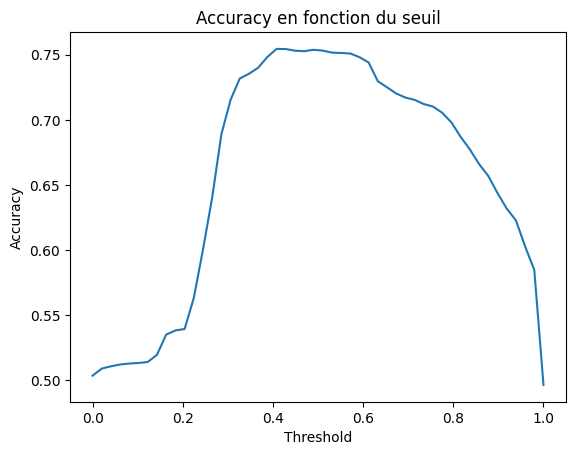

In [27]:
thresholds = np.linspace(0, 1, 50)
accuracies = []


for t in thresholds:
    y_temp = (y_proba >= t).astype(int)
    accuracies.append(accuracy_score(y_test, y_temp))


plt.figure()
plt.plot(thresholds, accuracies)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction du seuil")
plt.show()

In [22]:
# ...existing code...
from sklearn.metrics import roc_curve, auc

# Probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Export ROC points to CSV
import pandas as pd
roc_df = pd.DataFrame({
    'FPR': fpr,
    'TPR': tpr,
    'Threshold': thresholds
})
roc_df['AUC'] = roc_auc  # constant column for convenience

output_roc_csv = r'C:\Users\mk\Downloads\roc_curve_points.csv'
roc_df.to_csv(output_roc_csv, index=False, encoding='utf-8-sig')
print(f'✓ ROC points exported to: {output_roc_csv}')
print(f'AUC: {roc_auc:.4f}')

# Optional: also export Precision-Recall curve points
from sklearn.metrics import precision_recall_curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
pr_df = pd.DataFrame({
    'Recall': recall,
    'Precision': precision
})
output_pr_csv = r'C:\Users\mk\Downloads\precision_recall_points.csv'
pr_df.to_csv(output_pr_csv, index=False, encoding='utf-8-sig')
print(f'✓ PR points exported to: {output_pr_csv}')
# ...existing code...

✓ ROC points exported to: C:\Users\mk\Downloads\roc_curve_points.csv
AUC: 0.8279
✓ PR points exported to: C:\Users\mk\Downloads\precision_recall_points.csv
